In [ ]:
!pip install torch torchvision efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.6 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=2cd86738d6cc30951afcacef5292fc3740173b320934831ab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/My Drive//Datasets/Dataset"
train_dir = dataset_path + "/train"
test_dir = dataset_path + "/test"

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Optimizes performance on NVIDIA GPUs
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally 50% of the time
    transforms.RandomRotation(degrees=30),  # Rotate image up to ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
batch_size = 128  # Increase to 128 if memory allows

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['Acne', "Athlete's foot (tinea pedis)", 'Contact dermatitis', 'Eczema', 'Folliculitis', 'Impetigo', 'Lupus', 'Milia', 'Psoriasis', 'Ringworm (tinea corporis)', 'Rosacea', 'Scabies', 'Seborrheic dermatitis', 'Shingles', 'Vitiligo']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify classifier for 15 classes
num_ftrs = model._fc.in_features
model._fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout for regularization
    nn.Linear(num_ftrs, 15)  # Output 15 classes
)

model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 230MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Mixed Precision for T4 GPU
scaler = torch.cuda.amp.GradScaler()

<ipython-input-9-65ec65c3539d>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
best_val_loss = float("inf")
patience, counter = 5, 5  # Stop training if no improvement for 5 epochs

num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Enable mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():  # Enable mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Val Loss: {avg_val_loss:.4f} - "
          f"Val Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "/content/drive/My Drive/best_model.pth")  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

<ipython-input-11-066d98fb5be9>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision
<ipython-input-11-066d98fb5be9>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


Epoch [1/50] - Train Loss: 2.5494 - Val Loss: 2.4221 - Val Accuracy: 0.3558
Epoch [2/50] - Train Loss: 2.0755 - Val Loss: 1.7955 - Val Accuracy: 0.5100
Epoch [3/50] - Train Loss: 1.6080 - Val Loss: 1.3507 - Val Accuracy: 0.5750
Epoch [4/50] - Train Loss: 1.2756 - Val Loss: 1.0901 - Val Accuracy: 0.6300
Epoch [5/50] - Train Loss: 1.0375 - Val Loss: 0.9228 - Val Accuracy: 0.6975
Epoch [6/50] - Train Loss: 0.8760 - Val Loss: 0.7621 - Val Accuracy: 0.7425
Epoch [7/50] - Train Loss: 0.7329 - Val Loss: 0.6882 - Val Accuracy: 0.7783
Epoch [8/50] - Train Loss: 0.6143 - Val Loss: 0.6079 - Val Accuracy: 0.8067
Epoch [9/50] - Train Loss: 0.5238 - Val Loss: 0.5303 - Val Accuracy: 0.8317
Epoch [10/50] - Train Loss: 0.4468 - Val Loss: 0.4880 - Val Accuracy: 0.8525
Epoch [11/50] - Train Loss: 0.3817 - Val Loss: 0.4181 - Val Accuracy: 0.8717
Epoch [12/50] - Train Loss: 0.3167 - Val Loss: 0.4030 - Val Accuracy: 0.8775
Epoch [13/50] - Train Loss: 0.2717 - Val Loss: 0.3590 - Val Accuracy: 0.8892
Epoch [1

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/best_model.pth")
print("Training Completed! Model saved as best_model.pth")

Training Completed! Model saved as best_model.pth


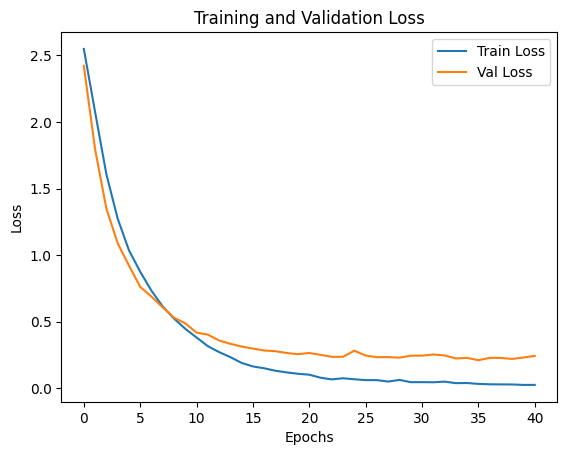

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()